# Mapping Coastal Water Quality Transect Data with Cartopy
Cartopy Source: https://scitools.org.uk/cartopy/docs/latest/_modules/cartopy/io/img_tiles.html. 

Here is some code that plots **geolocated** water quality sensor data on a cartopy basemap using Mapbox examples.

## Open in Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SUPScientist/Advanced-Quantitative-Oceanography/blob/main/notebooks/Intro_07_Xarray_and_plotting_with_cartopy.ipynb)

## Technical details
- I'm using cartopy 0.20.3: https://scitools.org.uk/cartopy/docs/latest/citation.html
- Here's cartopy's example for using the Stamen tiles: https://github.com/SciTools/cartopy/blob/main/examples/web_services/image_tiles.py. 
- Lots of other options for basemaps. See Map subheading for more.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Time zone conversions
Occasionally helpful to be able to convert from one time zone to another

In [2]:
import pytz
pacific = pytz.timezone('US/Eastern')

## Read in data using pandas
Pandas function "read_csv" pulls in a .csv file and can interpret the comma-separated values as corresponding to unique columns. 

In [3]:
df_full = pd.read_csv('Data/EXO2 data copied from Kor without headers - 071622 161323.csv', parse_dates=[0,1]) # Carolina Runner/Banks Channel

df_full.tail()

,Date (MM/DD/YYYY),Time (HH:mm:ss),Time (Fract. Sec),Site Name,Cond µS/cm,Depth m,nLF Cond µS/cm,ODO % sat,ODO % CB,ODO mg/L,...,pH,pH mV,Temp °C,Vertical Position m,GPS Latitude °,GPS Longitude °,Altitude m,Battery V,Cable Pwr V,Barometer mmHg
5819,2022-07-16,2022-08-29 15:42:39,0.0,<None>,60403.7,0.195,56259.1,84.6,84.2,5.33,...,8.21,-188.3,28.454,0.226,34.20454,-77.79978,-8.1,5.12,12.1,764.9
5820,2022-07-16,2022-08-29 15:42:40,0.0,<None>,60410.9,0.197,56262.0,84.6,84.2,5.33,...,8.21,-188.4,28.458,0.230,34.20452,-77.79977,-8.0,5.12,12.1,764.9
5821,2022-07-16,2022-08-29 15:42:41,0.0,<None>,60421.3,0.198,56266.2,84.7,84.3,5.34,...,8.21,-188.4,28.462,0.213,34.20450,-77.79977,-8.3,5.12,12.1,764.9
5822,2022-07-16,2022-08-29 15:42:42,0.0,<None>,60431.4,0.199,56270.0,84.7,84.3,5.34,...,8.21,-188.5,28.468,0.222,34.20449,-77.79976,-8.4,5.12,12.1,765.0
5823,2022-07-16,2022-08-29 15:42:43,0.0,<None>,60447.2,0.200,56274.6,84.8,84.4,5.34,...,8.21,-188.5,28.476,0.224,34.20447,-77.79975,-8.4,5.12,12.1,764.9


## Column headers
Pull from these columns when choosing what to plot below

In [4]:
df_full.columns

Index(['Date (MM/DD/YYYY)', 'Time (HH:mm:ss)', 'Time (Fract. Sec)',
       'Site Name', 'Cond µS/cm', 'Depth m', 'nLF Cond µS/cm', 'ODO % sat',
       'ODO % CB', 'ODO mg/L', 'Pressure psi a', 'Sal psu', 'SpCond µS/cm',
       'TDS mg/L', 'Turbidity FNU', 'TSS mg/L', 'pH', 'pH mV', 'Temp °C',
       'Vertical Position m', 'GPS Latitude °', 'GPS Longitude °',
       'Altitude m', 'Battery V', 'Cable Pwr V', 'Barometer mmHg'],
      dtype='object')

## Truncation
Often necessary to remove chunks of data due to known issues (e.g., sensor out of water during this time period). Check lab notebook for rationale and equate `df_trunc` to `df_full` if no truncation necessary

In [5]:
df_trunc = df_full#[19:335]
df_trunc.head()

,Date (MM/DD/YYYY),Time (HH:mm:ss),Time (Fract. Sec),Site Name,Cond µS/cm,Depth m,nLF Cond µS/cm,ODO % sat,ODO % CB,ODO mg/L,...,pH,pH mV,Temp °C,Vertical Position m,GPS Latitude °,GPS Longitude °,Altitude m,Battery V,Cable Pwr V,Barometer mmHg
0,2022-07-16,2022-08-29 14:05:41,0.0,<None>,60362.5,0.286,56573.5,85.2,84.8,5.39,...,8.4,-197.2,28.143,0.290,34.20412,-77.79978,-14.4,5.11,12.1,765.3
1,2022-07-16,2022-08-29 14:05:42,0.0,<None>,60358.0,0.286,56572.3,85.2,84.8,5.39,...,8.4,-197.2,28.141,0.303,34.20411,-77.79977,-11.3,5.11,12.1,765.2
2,2022-07-16,2022-08-29 14:05:43,0.0,<None>,60353.6,0.287,56571.3,85.1,84.7,5.39,...,8.4,-197.2,28.138,0.286,34.20411,-77.79974,-8.0,5.11,12.1,765.3
3,2022-07-16,2022-08-29 14:05:44,0.0,<None>,60349.2,0.287,56571.1,85.1,84.7,5.38,...,8.4,-197.2,28.135,0.288,34.20412,-77.79974,-10.9,5.11,12.1,765.2
4,2022-07-16,2022-08-29 14:05:45,0.0,<None>,60345.0,0.287,56570.5,85.0,84.6,5.38,...,8.4,-197.2,28.131,0.311,34.20414,-77.79976,-12.7,5.11,12.1,765.4


## Get parameters of interest and set limits

In [6]:
lat = df_trunc["GPS Latitude °"]
lon = df_trunc["GPS Longitude °"]
var_name = 'ODO % sat' # selected from columns above
plot_var = df_trunc[var_name]
plot_var_min  = min(plot_var) # set manually if desired
plot_var_max  = max(plot_var)
fontsize = 16

## Time-series plot of parameter of interest

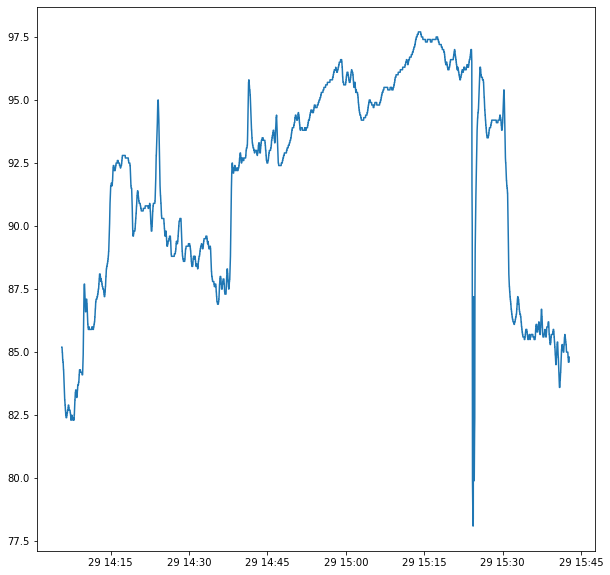

In [7]:
fig, axs = plt.subplots(figsize = (10, 10))
axs.plot(df_trunc['Time (HH:mm:ss)'], df_trunc[var_name])

## Map of variable of interest
- Image tile options via Cartopy are currently buried in the API under cartopy.io.img_tiles described here: https://scitools.org.uk/cartopy/docs/latest/_modules/cartopy/io/img_tiles.html. Scroll down to see different options under the different classes. Change the class 
- Here are some examples of the Mapbox style offerings: https://docs.mapbox.com/api/maps/styles/. Change `map_id` to use others.
- See also https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html for formatting.

### Options
See below for several examples. Then in subsequent cell, define which choice you'd like by setting `base_layer` and `tile_zoom` to match one of these examples.

In [8]:
# Map options: (un)comment blocks corresponding to choice and check to make sure base_layer and tile_zoom are defined
## Stamen
base_layer_stamen = cimgt.Stamen('terrain-background')
tile_zoom_stamen = 12

## Mapbox
map_id = 'satellite-streets-v11'
base_layer_mapbox = cimgt.MapboxTiles(mapbox_access_token, map_id=map_id)
tile_zoom_mapbox = 15

## Open Street Maps
base_layer_OSM = cimgt.OSM()
tile_zoom_OSM = 15

### Define your choices
Select corresponding options from prior cell

In [9]:
## DEFINE BASE_LAYER AND TILE_ZOOM HERE!
base_layer = base_layer_mapbox
tile_zoom = tile_zoom_mapbox

### Create plot
Using defined parameters from previous cell, create the plot

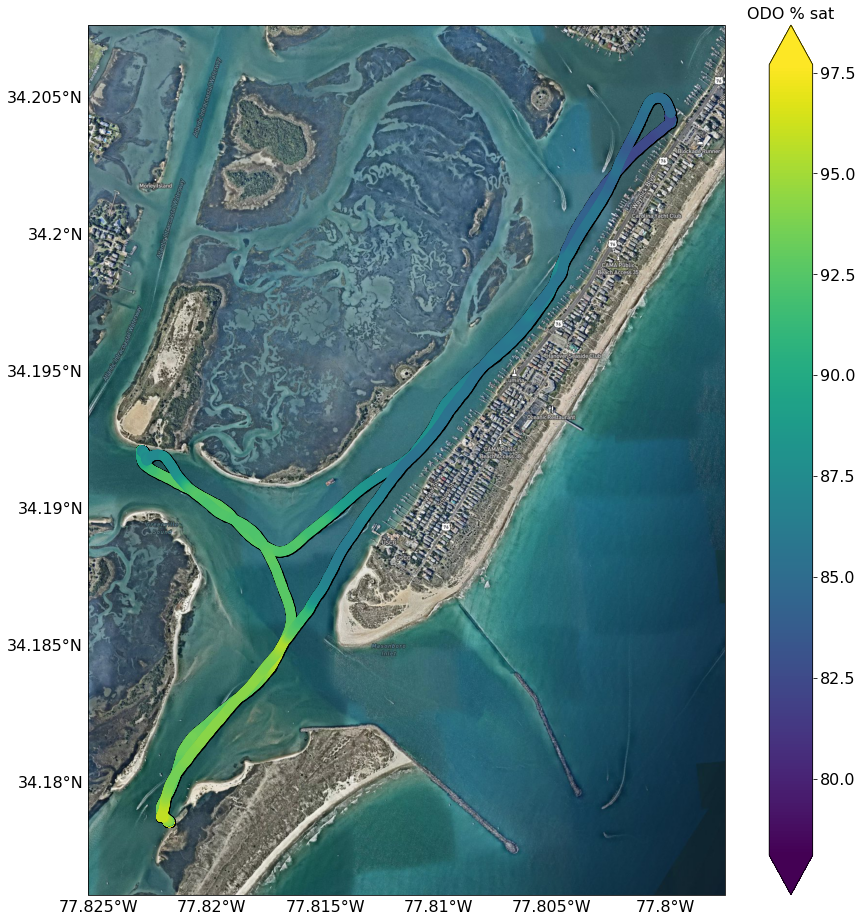

In [10]:
# Define CRS
crs = ccrs.PlateCarree() # won't work without this below

## Set plot lims
# Get current corners
lllat = np.nanmin(lat)
lllon = np.nanmin(lon)
urlat = np.nanmax(lat)
urlon = np.nanmax(lon)

# Calculate range in spatial vars
lat_diff = urlat-lllat
lon_diff = urlon-lllon

# How much padding to add--subjective
lat_frac = 0.1
lon_frac = 0.1

# Calculate new plot corners
lllat_plot = lllat-lat_diff*lat_frac
urlat_plot = urlat+lat_diff*lat_frac
lllon_plot = lllon-lon_diff*lon_frac
urlon_plot = urlon+lon_diff*lon_frac


fig = plt.figure(figsize = (16, 16))

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=base_layer.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon_plot, urlon_plot, lllat_plot, urlat_plot], crs=crs)

# Add the Stamen data at certain zoom level.
ax.add_image(base_layer, tile_zoom)

# Plot data
sc = plt.scatter(lon, lat, c = 'black', s = 100, transform = crs)
sc = plt.scatter(lon, lat, c = plot_var, s = 75, transform = crs, vmin = plot_var_min, vmax = plot_var_max)
cb = plt.colorbar(sc, extend = 'both')
cb.ax.tick_params(labelsize = fontsize) 
cb.ax.set_title(var_name, fontsize = fontsize)

# Format gridlines
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=2, color='white', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fontsize}#, 'color': 'gray'}
gl.ylabel_style = {'size': fontsize}#, 'color': 'gray'}

# plt.savefig(var_name+'.png', dpi = 300) # (un)comment depending on preference for saving figure locally